In [1]:
#train imports
import gym
import numpy as np
import os
import dill
import pickle
import tempfile
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

import logger
from schedules import LinearSchedule
from build_graph import build_act, build_train
from replay_buffer import ReplayBuffer, PrioritizedReplayBuffer

from atari_wrappers_deprecated import wrap_dqn, ScaledFloatFrame
import models
import simple
import tf_util as U

In [2]:
#Create a tmp file, remember to uncreate it later.
td = 'Expirements/'
expirement = 'exp_2'
environment = 'Pong'
model_saved = False
model_name = environment+'_'+expirement+'_model'
rewards_name = environment+'_'+expirement+'_rewards.pkl'
model_file = os.path.join(td, model_name)
rewards_file = os.path.join(td, rewards_name)

In [3]:
rewards_file

'Expirements/Pong_exp_2_rewards.pkl'

In [3]:
env = gym.make("PongNoFrameskip-v4")
env = ScaledFloatFrame(wrap_dqn(env))

[2017-08-31 22:18:51,027] Making new env: PongNoFrameskip-v4


In [4]:
model = models.cnn_to_mlp(
        convs=[(32, 8, 4), (64, 4, 2), (64, 3, 1)],
        hiddens=[256],
        dueling=True
    )

# Unroll of learn function

In [6]:
#Defining the parameter that were originally passed to the function
q_func=model
lr=1e-4
max_timesteps=500000
buffer_size=10000
exploration_fraction=0.1
exploration_final_eps=0.01
train_freq=4
learning_starts=10000
target_network_update_freq=1000
gamma=0.99
prioritized_replay=True

#default parameters
batch_size=32
print_freq=2
checkpoint_freq=10000
prioritized_replay_alpha=0.6
prioritized_replay_beta0=0.4
prioritized_replay_beta_iters=None
prioritized_replay_eps=1e-6
num_cpu=16
param_noise=False
callback=None

In [6]:
sess = U.make_session(num_cpu=num_cpu)
sess.__enter__()

In [7]:
#function for place holder
def make_obs_ph(name):
    return U.BatchInput(env.observation_space.shape, name=name)

#build train, what ever that could be
act, train, update_target, debug = build_train(
    make_obs_ph=make_obs_ph,
    q_func=q_func,
    num_actions=env.action_space.n,
    optimizer=tf.train.AdamOptimizer(learning_rate=lr),
    gamma=gamma,
    grad_norm_clipping=10,
    param_noise=param_noise
)

#act parameters
act_params = {
    'make_obs_ph': make_obs_ph,
    'q_func': q_func,
    'num_actions': env.action_space.n,
}

In [8]:
# Create the replay buffer
if prioritized_replay:
    replay_buffer = PrioritizedReplayBuffer(buffer_size, alpha=prioritized_replay_alpha)
    if prioritized_replay_beta_iters is None: #Still quite a mistery to me
        prioritized_replay_beta_iters = max_timesteps
    beta_schedule = LinearSchedule(prioritized_replay_beta_iters,
                                   initial_p=prioritized_replay_beta0,
                                   final_p=1.0)
else:
    replay_buffer = ReplayBuffer(buffer_size)
    beta_schedule = None

In [9]:
# Create the schedule for exploration starting from 1.
exploration = LinearSchedule(schedule_timesteps=int(exploration_fraction * max_timesteps),
                             initial_p=1.0,
                             final_p=exploration_final_eps)

In [10]:
# Initialize the parameters and copy them to the target network.
U.initialize()
update_target()

[]

In [11]:
#Here we go
episode_rewards = [0.0]
saved_mean_reward = None
obs = env.reset()
reset = True

In [12]:
#Here is the main loop
for t in range(max_timesteps):
    if callback is not None:
        if callback(locals(), globals()):
            break
    
    # update exploration epsilon or apply param_noise, if it is chosen
    kwargs = {}
    if not param_noise:
        update_eps = exploration.value(t)
        update_param_noise_threshold = 0.
    else:
        update_eps = 0.
        # Compute the threshold such that the KL divergence between perturbed and non-perturbed
        # policy is comparable to eps-greedy exploration with eps = exploration.value(t).
        # See Appendix C.1 in Parameter Space Noise for Exploration, Plappert et al., 2017
        # for detailed explanation.
        update_param_noise_threshold = -np.log(1. - exploration.value(t) + exploration.value(t) / float(env.action_space.n))
        kwargs['reset'] = reset
        kwargs['update_param_noise_threshold'] = update_param_noise_threshold
        kwargs['update_param_noise_scale'] = True
        
     
    
    #choose action and act
    action = act(np.array(obs)[None], update_eps=update_eps, **kwargs)[0]
    reset = False
    new_obs, rew, done, _ = env.step(action)
    
    # Store transition in the replay buffer.
    replay_buffer.add(obs, action, rew, new_obs, float(done))
    obs = new_obs
    
    #checks if game has ended
    episode_rewards[-1] += rew
    if done:
        obs = env.reset()
        episode_rewards.append(0.0)
        reset = True
        
    #training
    if t > learning_starts and t % train_freq == 0:
        #sample the experiences
        if prioritized_replay:
            experience = replay_buffer.sample(batch_size, beta=beta_schedule.value(t))
            (obses_t, actions, rewards, obses_tp1, dones, weights, batch_idxes) = experience
        else:
            obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(batch_size)
            weights, batch_idxes = np.ones_like(rewards), None
        
        #actual training step
        td_errors = train(obses_t, actions, rewards, obses_tp1, dones, weights)
        
        #Update priorities if prioritized replay on
        if prioritized_replay:
            new_priorities = np.abs(td_errors) + prioritized_replay_eps
            replay_buffer.update_priorities(batch_idxes, new_priorities)
    
    
    #update target network
    if t > learning_starts and t % target_network_update_freq == 0:
        # Update target network periodically.
        update_target()
    
    #keep stats on progress
    mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
    num_episodes = len(episode_rewards)
    
    #print every once in a while
    if done and print_freq is not None and len(episode_rewards) % print_freq == 0:
        print('steps', t, 'episodes', num_episodes,'reward', episode_rewards[-2], 'mean 100', mean_100ep_reward, 'e-value',
              exploration.value(t))
    
    #save models
    if (checkpoint_freq is not None and t > learning_starts and
        num_episodes > 100 and t % checkpoint_freq == 0):
        if saved_mean_reward is None or mean_100ep_reward > saved_mean_reward:
            if print_freq is not None:
                print('Saving model...')
            U.save_state(model_file)
            model_saved = True
            saved_mean_reward = mean_100ep_reward
            with open(rewards_file, 'wb') as f:
                pickle.dump(episode_rewards, f)
print('done, did %s steps' % (t+1))

/home/glazari/miniconda3/envs/dqn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/glazari/miniconda3/envs/dqn/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


steps 816 episodes 2 reward -21.0 mean 100 -21.0 e-value 0.9838432
steps 2654 episodes 4 reward -21.0 mean 100 -20.3 e-value 0.9474508
steps 4627 episodes 6 reward -21.0 mean 100 -20.2 e-value 0.9083854
steps 6384 episodes 8 reward -20.0 mean 100 -20.3 e-value 0.8735968000000001
steps 8003 episodes 10 reward -21.0 mean 100 -20.3 e-value 0.8415406
steps 9661 episodes 12 reward -21.0 mean 100 -20.5 e-value 0.8087122
steps 11570 episodes 14 reward -21.0 mean 100 -20.3 e-value 0.770914
steps 13289 episodes 16 reward -21.0 mean 100 -20.4 e-value 0.7368778
steps 14999 episodes 18 reward -21.0 mean 100 -20.4 e-value 0.7030198
steps 16913 episodes 20 reward -19.0 mean 100 -20.3 e-value 0.6651226
steps 18683 episodes 22 reward -20.0 mean 100 -20.3 e-value 0.6300766
steps 20305 episodes 24 reward -21.0 mean 100 -20.4 e-value 0.597961
steps 22090 episodes 26 reward -21.0 mean 100 -20.4 e-value 0.562618
steps 23835 episodes 28 reward -20.0 mean 100 -20.4 e-value 0.5280670000000001
steps 25490 epis

steps 367999 episodes 200 reward 17.0 mean 100 -0.9 e-value 0.010000000000000009
Saving model...
steps 372329 episodes 202 reward 10.0 mean 100 -0.3 e-value 0.010000000000000009
steps 375574 episodes 204 reward 20.0 mean 100 0.4 e-value 0.010000000000000009
steps 379682 episodes 206 reward 18.0 mean 100 1.1 e-value 0.010000000000000009
Saving model...
steps 383645 episodes 208 reward 16.0 mean 100 1.7 e-value 0.010000000000000009
steps 387406 episodes 210 reward 19.0 mean 100 2.4 e-value 0.010000000000000009
Saving model...
steps 391227 episodes 212 reward 17.0 mean 100 2.9 e-value 0.010000000000000009
steps 396082 episodes 214 reward 14.0 mean 100 3.4 e-value 0.010000000000000009
Saving model...
steps 400657 episodes 216 reward 12.0 mean 100 4.0 e-value 0.010000000000000009
steps 404559 episodes 218 reward 17.0 mean 100 4.7 e-value 0.010000000000000009
steps 408408 episodes 220 reward 20.0 mean 100 5.2 e-value 0.010000000000000009
Saving model...
steps 412681 episodes 222 reward 19.0 

'Expirements/Pong_exp_2_model'

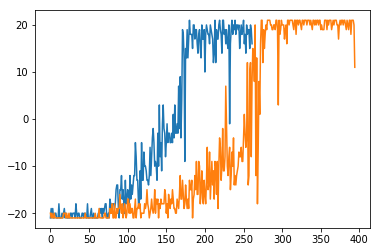

In [24]:
a = episode_rewards[0:-1]
plt.plot(a)
plt.plot(b)
model_file

In [21]:
c = pickle.load( open( "Expirements/Pong_exp_2_rewards.pkl", "rb" ) )

[-20.0,
 -21.0,
 -20.0,
 -21.0,
 -21.0,
 -20.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -20.0,
 -20.0,
 -20.0,
 -21.0,
 -20.0,
 -21.0,
 -21.0,
 -20.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -20.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -20.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -19.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -20.0,
 -20.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -19.0,
 -20.0,
 -20.0,
 -18.0,
 -21.0,
 -21.0,
 -18.0,
 -21.0,
 -21.0,
 -19.0,
 -20.0,
 -19.0,
 -19.0,
 -16.0,
 -19.0,
 -20.0,
 -18.0,
 -21.0,
 -20.0,
 -18.0,
 -19.0,
 -21.0,
 -20.0,
 -17.0,
 -17.0,
 -20.0,
 -18.0,
 -20.0,
 -19.0,
 -19.0,
 -21.0,
 -21.0,
 -19.0,
 -17.0,
 -21.0,
 -19.0,
 -19.0,
 -18.0,
 -19.0,
 -18.0,
 -21.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -18.0,
 -19.0,
 -18.0,
